In [10]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import keras

%matplotlib inline

In [11]:
import pickle

from keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import ZeroPadding2D, Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization

In [12]:
with open("faces_dataset_conv.pickle", "rb") as f:
    data = pickle.load(f)

In [25]:
train_ds = data["train_dataset"]
train_labels = data["train_labels"]
pub_test_ds = data["public_test"]
pub_test_labels = data["public_test_labels"]
priv_test_ds = data["private_test"]
priv_test_labels = data["private_test_labels"]

In [26]:
priv_test_labels_no_cat = priv_test_labels

In [27]:
train_ds_inv = train_ds.reshape(train_ds.shape[0], 48, 48, 1)
pub_test_ds_inv = pub_test_ds.reshape(pub_test_ds.shape[0], 48, 48, 1)
priv_test_ds_inv = priv_test_ds.reshape(priv_test_ds.shape[0],48, 48, 1)
train_bigger_inv = np.vstack([train_ds_inv, pub_test_ds_inv])

train_labels = np_utils.to_categorical(train_labels, 7)
pub_test_labels = np_utils.to_categorical(pub_test_labels, 7)
priv_test_labels = np_utils.to_categorical(priv_test_labels, 7)
train_bigger_labels = np.concatenate([train_labels, pub_test_labels])

In [15]:
def get_model(weights=None):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(48, 48, 1)))
    model.add(Convolution2D(filters=1, kernel_size=1))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.1))
    
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Convolution2D(filters=8, kernel_size=2))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Convolution2D(filters=16, kernel_size=2, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(filters=32, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))

    model.add(MaxPooling2D(pool_size=2, strides=1))
#     model.add(Dropout(0.2))
    
    model.add(ZeroPadding2D(padding=(3, 3)))
    model.add(Convolution2D(filters=128, kernel_size=4))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Convolution2D(filters=128, kernel_size=4, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.3))
    
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Convolution2D(filters=32, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Convolution2D(filters=16, kernel_size=2, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Flatten())
    ##fully connected
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.6))
    
    model.add(Dense(units=7, activation="softmax"))
    
    if weights:
        model.load_weights(weights)
    
    return model

In [16]:
model = get_model()

(None, 28, 28, 128)


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 1)         2         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 1)         4         
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 1)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 52, 52, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 8)         40        
__________

In [12]:
filepath = "weights-improvement-{val_loss:.2f}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [21]:
# del model
import gc
# del model_res
gc.collect()

35454

In [54]:
def get_module_with_residules(weights=None):
    img_input = Input((48, 48, 1))
    
    x = Convolution2D(32, (3, 3), strides=(1, 1), use_bias=False, padding='same')(img_input)
    
#     x = Convolution2D(32, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)

    x = BatchNormalization()(x)
    
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    x = Dropout(0.1)(x)

    x = Convolution2D(32, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)
    
#     x = Convolution2D(32, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)

    x = BatchNormalization()(x)
    
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    x = Dropout(0.2)(x)
    
    print(x.shape)

    
#     x = layers.add([x, residual])
    
#     residual = Convolution2D(64, (3, 3), strides=(1, 1), use_bias=False, padding="same")(x)
#     residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)
#     residual = BatchNormalization()(residual)
    
    x = Convolution2D(64, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)
    
#     x = Convolution2D(64, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)

    x = BatchNormalization()(x)
    
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    x = Dropout(0.3)(x)


    x = Convolution2D(64, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)
    
#     x = Convolution2D(64, (3, 3), strides=(1, 1), use_bias=False,padding='same')(x)

    x = BatchNormalization()(x)
   
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#     x = Dropout(0.4)(x)

    
#     x = layers.add([x, residual])
    
#     residual = Convolution2D(128, (3, 3), strides=(1, 1),
#                       padding='same', use_bias=False)(x)
#     residual = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(residual)

#     residual = BatchNormalization()(residual)
    
    x = Convolution2D(128, (3, 3), strides=(1, 1), use_bias=False, padding='same')(x)
    
#     x = Convolution2D(128, (3, 3), strides=(1, 1), use_bias=False,padding='same')(x)

    x = BatchNormalization()(x)
    
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
#     x = Dropout(0.4)(x)


    x = Convolution2D(128, (3, 3), strides=(1, 1), use_bias=False,padding='same')(x)
    
#     x = Convolution2D(128, (3, 3), strides=(1, 1), use_bias=False,padding='same')(x)

    x = BatchNormalization()(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Dropout(0.4)(x)

    
#     x = layers.add([x, residual])
    x = Flatten()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(units=256, activation="relu")(x)
    x = Dropout(0.5)(x)    
    x = Dense(units=7, activation="softmax")(x)
#     output = Activation('softmax',name='predictions')(x)
    model = Model(img_input, x)
    return model



In [55]:
model_res = get_module_with_residules()

(?, 48, 48, 32)


In [3]:
from keras.utils import multi_gpu_model
# model_res = multi_gpu_model(model_res, gpus=2)

In [7]:
from keras.optimizers import Adam

In [57]:
model_res.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
history_res = model_res.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=1, verbose=1, callbacks=callback_list)

Train on 28709 samples, validate on 3589 samples
Epoch 1/1
28709/28709 [==============================] - 45s 2ms/step - loss: 12.0522 - acc: 0.2509 - val_loss: 12.0987 - val_acc: 0.2494

Epoch 00001: val_acc did not improve from 0.51156


In [44]:
model_res.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_res = model_res.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=2, verbose=1, callbacks=callback_list)

Train on 28709 samples, validate on 3589 samples
Epoch 1/2
28709/28709 [==============================] - 47s 2ms/step - loss: 1.2803 - acc: 0.5123 - val_loss: 1.3638 - val_acc: 0.4912

Epoch 00001: val_acc improved from 0.48370 to 0.49122, saving model to weights-improvement-1.36-0.4912.hdf5
Epoch 2/2
28709/28709 [==============================] - 42s 1ms/step - loss: 1.1579 - acc: 0.5620 - val_loss: 1.3088 - val_acc: 0.5116

Epoch 00002: val_acc improved from 0.49122 to 0.51156, saving model to weights-improvement-1.31-0.5116.hdf5


## try normal conv net

In [8]:
def get_model_normal(weights=None):
    model = Sequential()
    filters = 64
    model.add(Convolution2D(filters, input_shape=(48, 48, 1), kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(2 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(4 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(8 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2 * filters, kernel_size=(3, 3), strides=(1, 1), use_bias=False, padding='same'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(8 * filters, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(4 * filters, activation="relu"))  
    model.add(Dropout(0.5))

    model.add(Dense(2 * filters, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))
    return model

In [66]:
get_model_normal().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 48, 48, 64)        576       
_________________________________________________________________
batch_normalization_122 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 24, 24, 128)       73728     
_________________________________________________________________
batch_normalization_123 (Bat (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 12, 12, 128)       0         
__________

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [80]:
norm_model = get_model_normal()
model_norm = multi_gpu_model(norm_model, gpus=2)

model_norm.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history_res = model_norm.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=100, verbose=1, callbacks=[early_stopper, lr_reducer, checkpoint])

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 41s 1ms/step - loss: 2.0732 - acc: 0.2043 - val_loss: 1.8303 - val_acc: 0.2494

Epoch 00001: val_acc improved from -inf to 0.24937, saving model to weights-improvement-1.83-0.2494.hdf5
Epoch 2/100
28709/28709 [==============================] - 28s 983us/step - loss: 1.8351 - acc: 0.2448 - val_loss: 1.8184 - val_acc: 0.2494

Epoch 00002: val_acc did not improve from 0.24937
Epoch 3/100
28709/28709 [==============================] - 28s 980us/step - loss: 1.8206 - acc: 0.2492 - val_loss: 1.8028 - val_acc: 0.2494

Epoch 00003: val_acc did not improve from 0.24937
Epoch 4/100
28709/28709 [==============================] - 28s 984us/step - loss: 1.8021 - acc: 0.2563 - val_loss: 1.7702 - val_acc: 0.2700

Epoch 00004: val_acc improved from 0.24937 to 0.26999, saving model to weights-improvement-1.77-0.2700.hdf5
Epoch 5/100
28709/28709 [==============================] - 28s 975us/step - 

In [13]:
norm_model2 = get_model_normal()
model_norm2 = multi_gpu_model(norm_model2, gpus=2)

model_norm2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history_res2 = model_norm2.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=100, verbose=1, callbacks=[early_stopper, lr_reducer, checkpoint])

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 31s 1ms/step - loss: 2.0262 - acc: 0.2089 - val_loss: 1.8189 - val_acc: 0.2494

Epoch 00001: val_acc improved from -inf to 0.24937, saving model to weights-improvement-1.82-0.2494.hdf5
Epoch 2/100
28709/28709 [==============================] - 26s 920us/step - loss: 1.8364 - acc: 0.2468 - val_loss: 1.8090 - val_acc: 0.2494

Epoch 00002: val_acc did not improve from 0.24937
Epoch 3/100
28709/28709 [==============================] - 26s 916us/step - loss: 1.8264 - acc: 0.2500 - val_loss: 1.8186 - val_acc: 0.2494

Epoch 00003: val_acc did not improve from 0.24937
Epoch 4/100
28709/28709 [==============================] - 26s 919us/step - loss: 1.8113 - acc: 0.2507 - val_loss: 1.7660 - val_acc: 0.2619

Epoch 00004: val_acc improved from 0.24937 to 0.26191, saving model to weights-improvement-1.77-0.2619.hdf5
Epoch 5/100
28709/28709 [==============================] - 26s 916us/step - 

In [4]:
from keras.regularizers import l2

In [20]:
def one_more_model():
    model = Sequential()
    num_features = 64
    num_labels = 7
    model.add(Convolution2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Convolution2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels, activation='softmax'))
    return model

In [21]:
norm_model3 = one_more_model()
model_norm3 = multi_gpu_model(norm_model3, gpus=2)

model_norm3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history_res3 = model_norm3.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=100, verbose=1, callbacks=[early_stopper, lr_reducer, checkpoint])

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 47s 2ms/step - loss: 2.0066 - acc: 0.2148 - val_loss: 1.8373 - val_acc: 0.2494

Epoch 00001: val_acc improved from -inf to 0.24937, saving model to weights-improvement-1.84-0.2494.hdf5
Epoch 2/100
28709/28709 [==============================] - 41s 1ms/step - loss: 1.8374 - acc: 0.2431 - val_loss: 1.8196 - val_acc: 0.2494

Epoch 00002: val_acc did not improve from 0.24937
Epoch 3/100
28709/28709 [==============================] - 41s 1ms/step - loss: 1.8221 - acc: 0.2497 - val_loss: 1.8191 - val_acc: 0.2494

Epoch 00003: val_acc did not improve from 0.24937
Epoch 4/100
28709/28709 [==============================] - 42s 1ms/step - loss: 1.8021 - acc: 0.2566 - val_loss: 1.7541 - val_acc: 0.2948

Epoch 00004: val_acc improved from 0.24937 to 0.29479, saving model to weights-improvement-1.75-0.2948.hdf5
Epoch 5/100
28709/28709 [==============================] - 41s 1ms/step - loss: 1.

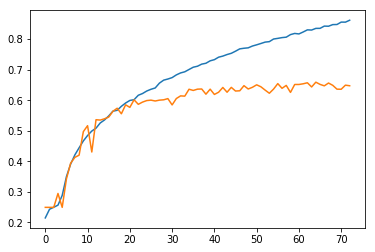

In [26]:
plt.plot(history_res3.history['acc'])
plt.plot(history_res3.history['val_acc'])

In [43]:
max(history_res3.history['val_acc'])

0.6589579270074679

In [47]:
model_norm3.save("one_more_model.hdf5")

In [44]:
model_norm3.evaluate(priv_test_ds_inv, priv_test_labels)

3589/3589 [==============================] - 4s 991us/step


[1.2428163068478537, 0.6597938144371416]

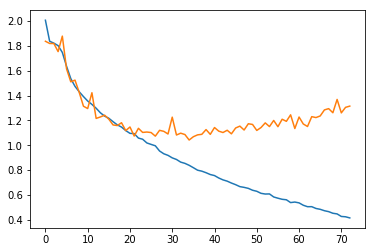

In [27]:
plt.plot(history_res3.history['loss'])
plt.plot(history_res3.history['val_loss'])

In [28]:
def model_experiment():
    model = Sequential()
    num_features = 64
    num_labels = 7
    model.add(Convolution2D(num_features, kernel_size=(4, 4), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Convolution2D(num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Convolution2D(2*2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
#     model.add(Dense(2*2*num_features, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(num_labels, activation='softmax'))
    return model

In [30]:
model_exp = model_experiment()
model_norm4 = multi_gpu_model(model_exp, gpus=2)

model_norm4.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

filepath = "experimental-{val_loss:.2f}-{val_acc:.4f}.hdf5"

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=8, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history_res4 = model_norm4.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=100, verbose=1, callbacks=[early_stopper, lr_reducer, checkpoint])

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 74s 3ms/step - loss: 1.9747 - acc: 0.2310 - val_loss: 1.8163 - val_acc: 0.2494

Epoch 00001: val_acc improved from -inf to 0.24937, saving model to experimental-1.82-0.2494.hdf5
Epoch 2/100
28709/28709 [==============================] - 67s 2ms/step - loss: 1.8327 - acc: 0.2511 - val_loss: 1.8212 - val_acc: 0.2491

Epoch 00002: val_acc did not improve from 0.24937
Epoch 3/100
28709/28709 [==============================] - 67s 2ms/step - loss: 1.7791 - acc: 0.2775 - val_loss: 1.7101 - val_acc: 0.2973

Epoch 00003: val_acc improved from 0.24937 to 0.29730, saving model to experimental-1.71-0.2973.hdf5
Epoch 4/100
28709/28709 [==============================] - 67s 2ms/step - loss: 1.7087 - acc: 0.3081 - val_loss: 1.8085 - val_acc: 0.2965

Epoch 00004: val_acc did not improve from 0.29730
Epoch 5/100
28709/28709 [==============================] - 67s 2ms/step - loss: 1.6359 - acc: 0.

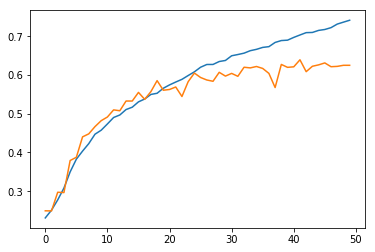

In [31]:
plt.plot(history_res4.history['acc'])
plt.plot(history_res4.history['val_acc'])

In [42]:
max(history_res4.history['val_acc'])

0.6391752577402625

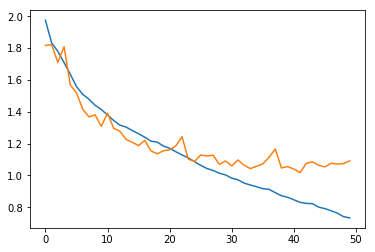

In [41]:
plt.plot(history_res4.history['loss'])
plt.plot(history_res4.history['val_loss'])

In [5]:
def model_experiment_2():
    model = Sequential()
    num_features = 128
    num_labels = 7
    model.add(Convolution2D(num_features, kernel_size=(4, 4), activation='relu', input_shape=(48, 48, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Convolution2D(num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Convolution2D(2*2*2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*2*num_features, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))
    
    model.add(Convolution2D(2*2*2*num_features, kernel_size=(2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(2*2*2*num_features, kernel_size=(2, 2), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.6))

    model.add(Flatten())

    model.add(Dense(2*2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
#     model.add(Dense(2*2*num_features, activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(num_labels, activation='softmax'))
    return model

In [35]:
model_exp_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 45, 45, 128)       2176      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 45, 45, 128)       262272    
_________________________________________________________________
batch_normalization_38 (Batc (None, 45, 45, 128)       512       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 22, 22, 256)       524544    
_________________________________________________________________
batch_normalization_39 (Batc (None, 22, 22, 256)       1024      
__________

In [ ]:
model_exp_2 = model_experiment_2()
model_norm5 = multi_gpu_model(model_exp_2, gpus=2)

model_norm5.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

filepath = "experimental-{val_loss:.2f}-{val_acc:.4f}.hdf5"

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=15, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


history_res5 = model_norm5.fit(train_ds_inv, train_labels, 
          batch_size=64, validation_data=[pub_test_ds_inv, pub_test_labels], epochs=100, verbose=1, callbacks=[early_stopper, lr_reducer, checkpoint])

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 217s 8ms/step - loss: 1.9119 - acc: 0.2379 - val_loss: 1.8036 - val_acc: 0.2505

Epoch 00001: val_acc improved from -inf to 0.25049, saving model to experimental-1.80-0.2505.hdf5
Epoch 2/100
28709/28709 [==============================] - 207s 7ms/step - loss: 1.8217 - acc: 0.2601 - val_loss: 1.8203 - val_acc: 0.2494

Epoch 00002: val_acc did not improve from 0.25049
Epoch 3/100
28709/28709 [==============================] - 208s 7ms/step - loss: 1.7554 - acc: 0.2935 - val_loss: 1.6729 - val_acc: 0.3497

Epoch 00003: val_acc improved from 0.25049 to 0.34968, saving model to experimental-1.67-0.3497.hdf5
Epoch 4/100
28709/28709 [==============================] - 207s 7ms/step - loss: 1.6665 - acc: 0.3308 - val_loss: 1.8493 - val_acc: 0.2502

Epoch 00004: val_acc did not improve from 0.34968
Epoch 5/100
28709/28709 [==============================] - 207s 7ms/step - loss: 1.5887 - ac

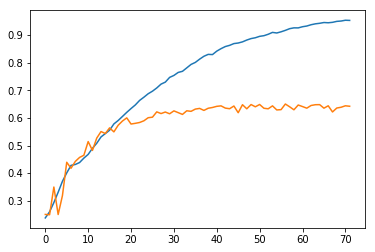

In [38]:
plt.plot(history_res5.history['acc'])
plt.plot(history_res5.history['val_acc'])

In [40]:
max(history_res5.history["val_acc"])

0.6503204235246036

In [45]:
model_norm5.evaluate(priv_test_ds_inv, priv_test_labels)

3589/3589 [==============================] - 11s 3ms/step


[1.477180510825784, 0.6567288938589035]

In [46]:
model_norm5.save("experiment_2.hdf5")

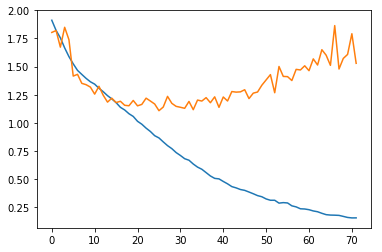

In [39]:
plt.plot(history_res5.history['loss'])
plt.plot(history_res5.history['val_loss'])

In [6]:
from keras.models import load_model


In [8]:
keras.__version__

'2.2.0'

In [7]:
mod = load_model("experiment_2.hdf5")

## Plot confusion matrices

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

In [20]:
pred = mod.predict(priv_test_ds_inv)

In [21]:
pred = np.argmax(pred, axis=1)

In [24]:
priv_test_labels.shape

(3589, 7)

In [29]:
names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [28]:
conf_matrix_experiment2 = confusion_matrix(priv_test_labels_no_cat, pred)

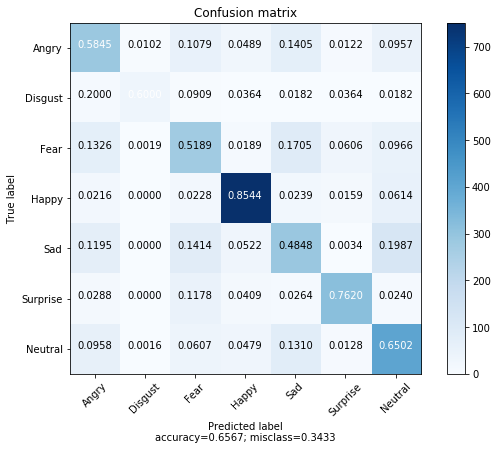

In [31]:
plot_confusion_matrix(conf_matrix_experiment2, names)

## One more

In [32]:
one_more_model = load_model("one_more_model.hdf5")

In [33]:
def get_conf_matrix(model, test_ds, test_labels):
    names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    print("Predicting...")
    pred = model.predict(test_ds)
    pred = np.argmax(pred, axis=1)
    conf_matrix = confusion_matrix(test_labels, pred)
    print("Plotting")
    plot_confusion_matrix(conf_matrix, names)

Predicting...
Plotting


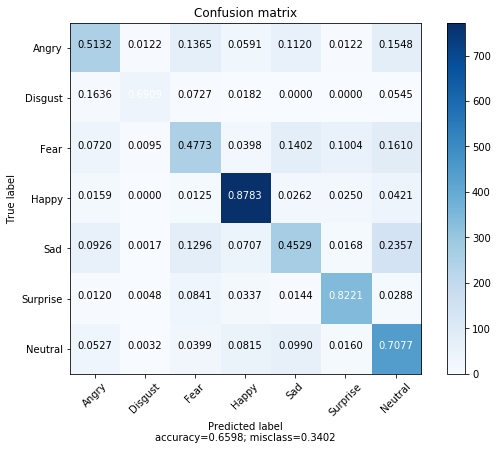

In [34]:
get_conf_matrix(one_more_model, priv_test_ds_inv, priv_test_labels_no_cat)